In [89]:
import pandas as pd
import numpy as np
from utils import *

In [90]:
df = pd.read_csv('files/Sunspots.csv')
df.rename(columns={'Unnamed: 0': 'Time Step'}, inplace=True)

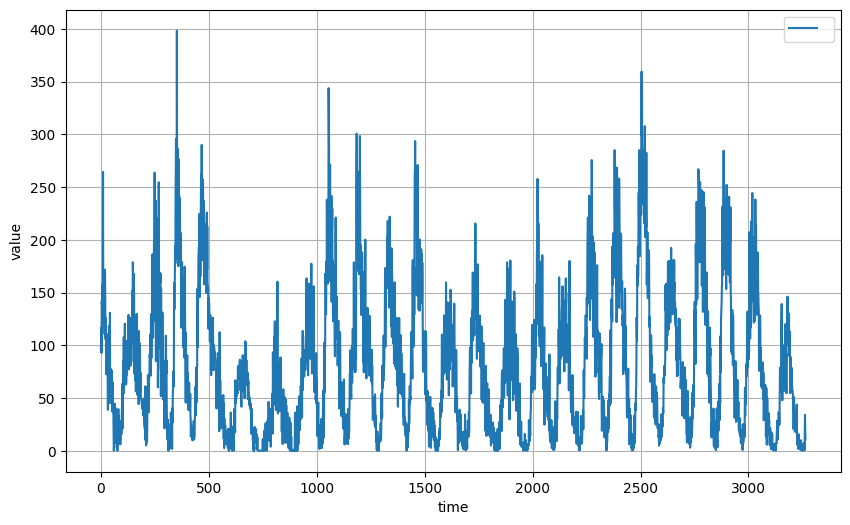

In [91]:
plot_series(df['Time Step'].unique(), df['Monthly Mean Total Sunspot Number'])

In [92]:
split_time = 3000
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

time_train = df['Time Step'].values[:split_time]
x_train = df['Monthly Mean Total Sunspot Number'].values[:split_time]

time_valid = df['Time Step'].values[split_time:]
x_valid = df['Monthly Mean Total Sunspot Number'].values[split_time:]

In [93]:
dataset = generate_windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [94]:
import tensorflow as tf

tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Lambda(lambda x: x * 200))
pd.Series.as
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(dataset, epochs=500)

Epoch 1/500
93/93 [==============================] - 5s 13ms/step - loss: 31.6830 - mae: 32.1792
Epoch 2/500
93/93 [==============================] - 1s 13ms/step - loss: 22.3516 - mae: 22.8463
Epoch 3/500
93/93 [==============================] - 1s 12ms/step - loss: 19.6333 - mae: 20.1261
Epoch 4/500
93/93 [==============================] - 1s 12ms/step - loss: 20.2501 - mae: 20.7438
Epoch 5/500
93/93 [==============================] - 1s 12ms/step - loss: 20.2009 - mae: 20.6951
Epoch 6/500
93/93 [==============================] - 1s 14ms/step - loss: 19.5945 - mae: 20.0888
Epoch 7/500
93/93 [==============================] - 1s 12ms/step - loss: 18.9395 - mae: 19.4325
Epoch 8/500
93/93 [==============================] - 1s 12ms/step - loss: 18.5001 - mae: 18.9922
Epoch 9/500
93/93 [==============================] - 1s 12ms/step - loss: 18.6657 - mae: 19.1578
Epoch 10/500
93/93 [==============================] - 1s 12ms/step - loss: 18.7959 - mae: 19.2890
Epoch 11/500
93/93 [=========

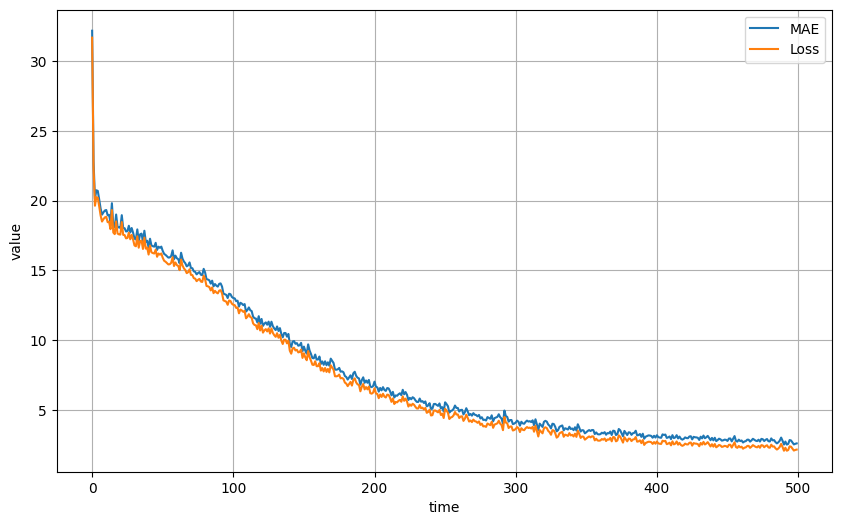

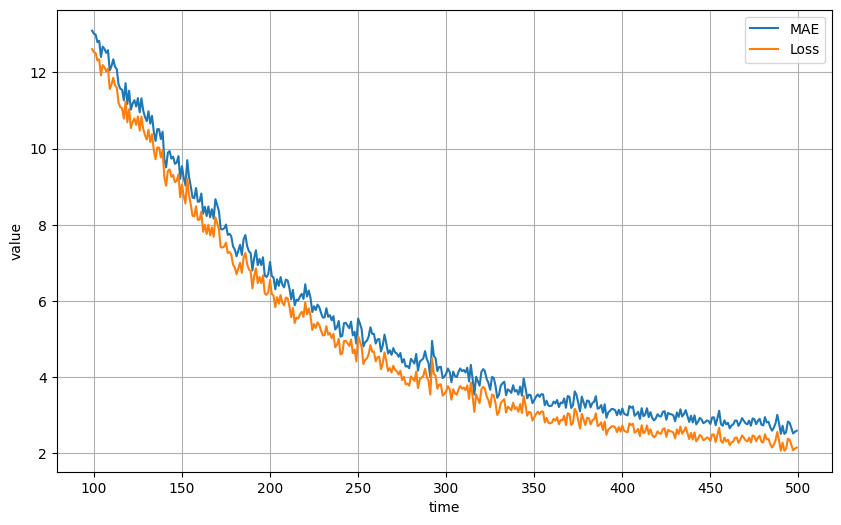

In [101]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    epochs, 
    (mae, loss), 
    legend_labels=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    epochs_zoom, 
    (mae_zoom, loss_zoom), 
    legend_labels=['MAE', 'Loss']
    )

In [ ]:
dataset_predict = tf.data.Dataset.from_tensor_slices(df['Monthly Mean Total Sunspot Number'][split_time-window_size:-1])
dataset_predict = dataset_predict.window(window_size, shift=1, drop_remainder=True)
dataset_predict = dataset_predict.flat_map(lambda window: window.batch(window_size))
dataset_predict = dataset_predict.batch(batch_size).prefetch(1)

forecast = model.predict(dataset_predict)

In [ ]:
forecast.shape

In [ ]:
x_valid.shape

15.359347


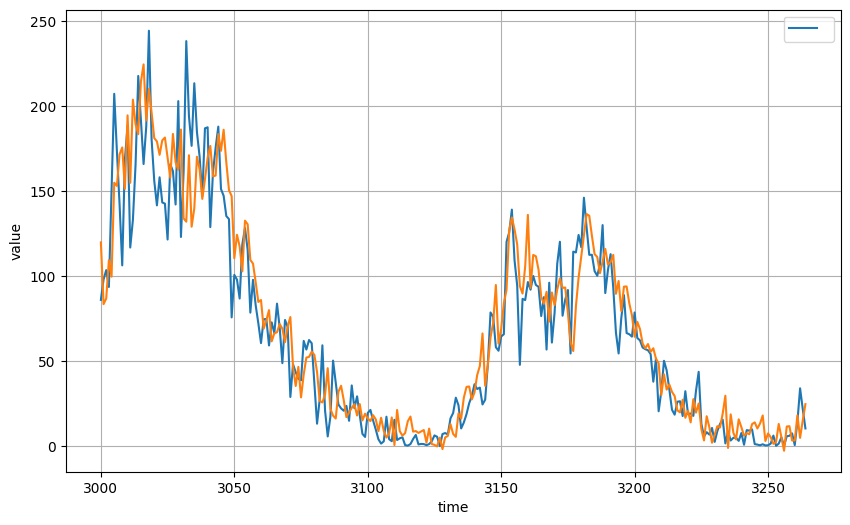

In [102]:
print(tf.keras.metrics.mean_absolute_error(x_valid, forecast.squeeze()).numpy())
plot_series(time_valid, (x_valid, forecast))